# Time-strain inversion of the Hess 4D modeled post-stack seismic data 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import time 
import numpy as np
import matplotlib.pyplot as plt
from pylops.avo.poststack import PoststackLinearModelling
from strainprox.utils import apply_time_shift, plot_results, plotter_4D
from strainprox.functions import strain_jis
from pylops import CausalIntegration
from pylops.basicoperators import Gradient, Diagonal, FirstDerivative
from pyproximal import L21, L2
from matplotlib.colors import ListedColormap, BoundaryNorm

## Data loading and visualization

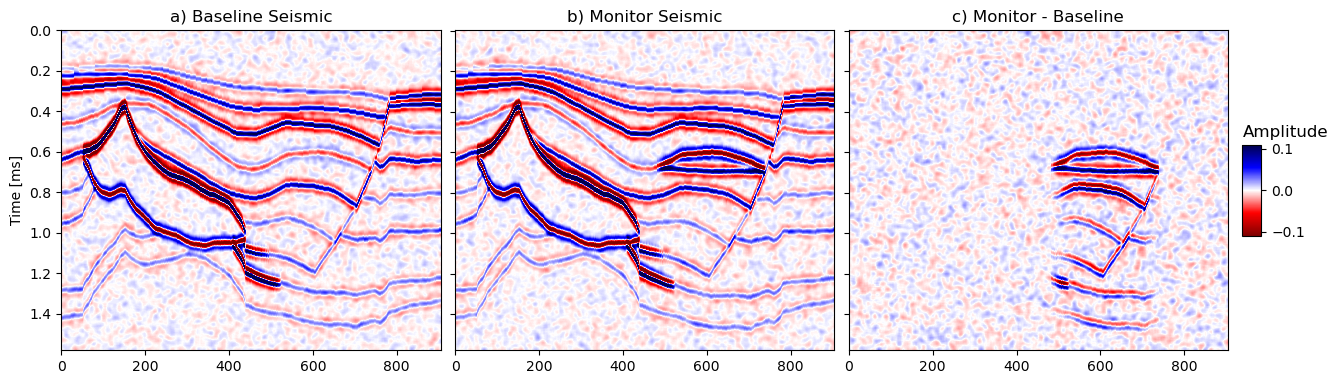

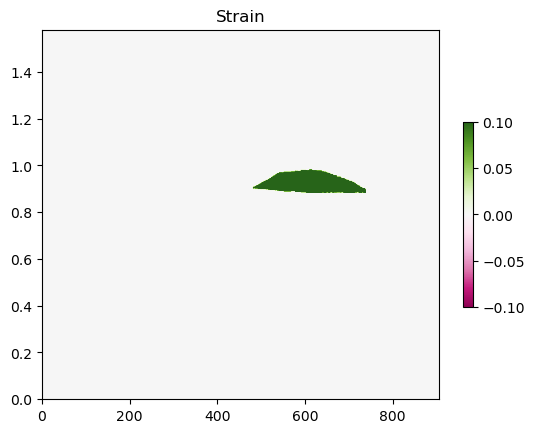

In [2]:
# We load the Hess 4D dataset which contains:
# - Baseline seismic data (d1)
# - Monitor seismic data (d2)
# - Wavelet (wav)
# - Ground truth strain (utrue)

dtype = 'float64'
hess = np.load('../data/Hess/Hess4d_time.npz')
wav = hess['wav'].astype(np.float32)
d1 = hess['dn1'].astype(np.float32)
d2 = hess['dn2'].astype(np.float32)
utrue = hess['straint'].astype(np.float32)
dims = utrue.shape
dt = 0.004
t = np.arange(dims[0], dtype=dtype)*dt

plotter_4D(d1, d2, dt=dt, ztitle='Time [ms]', type='seismic')
plt.show()
plt.imshow(utrue, cmap='PiYG', vmin=-0.1, vmax=0.1, extent=(0, dims[1], 0, dims[0]*dt))
plt.title('Strain')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()

## Time-strain inversion

$$
     \Delta u = \argmin_{\Delta u}\Vert d_1(t) - d_2(t+ dt C  u_{i-1}) - dt  J_{d_2} C \Delta u \Vert^2  + \Vert \nabla (\Delta u + u_{i-1})\Vert_{1}
$$

iter: 0, SNR: 0.3181
iter: 10, SNR: 1.9139
iter: 20, SNR: 2.2879
iter: 30, SNR: 2.5164
iter: 40, SNR: 2.6609
Total time: 120.41 s


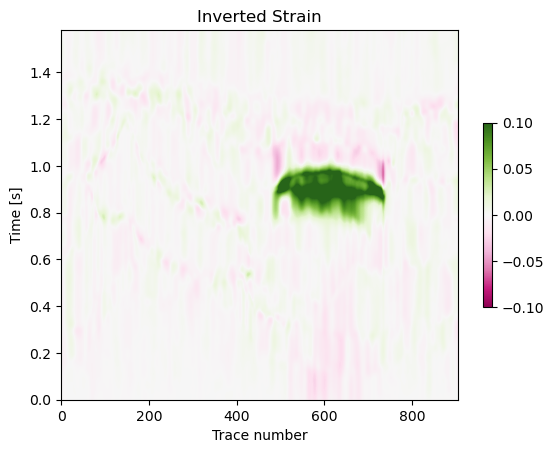

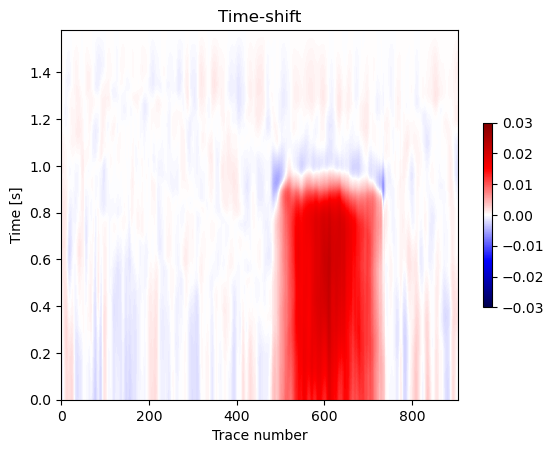

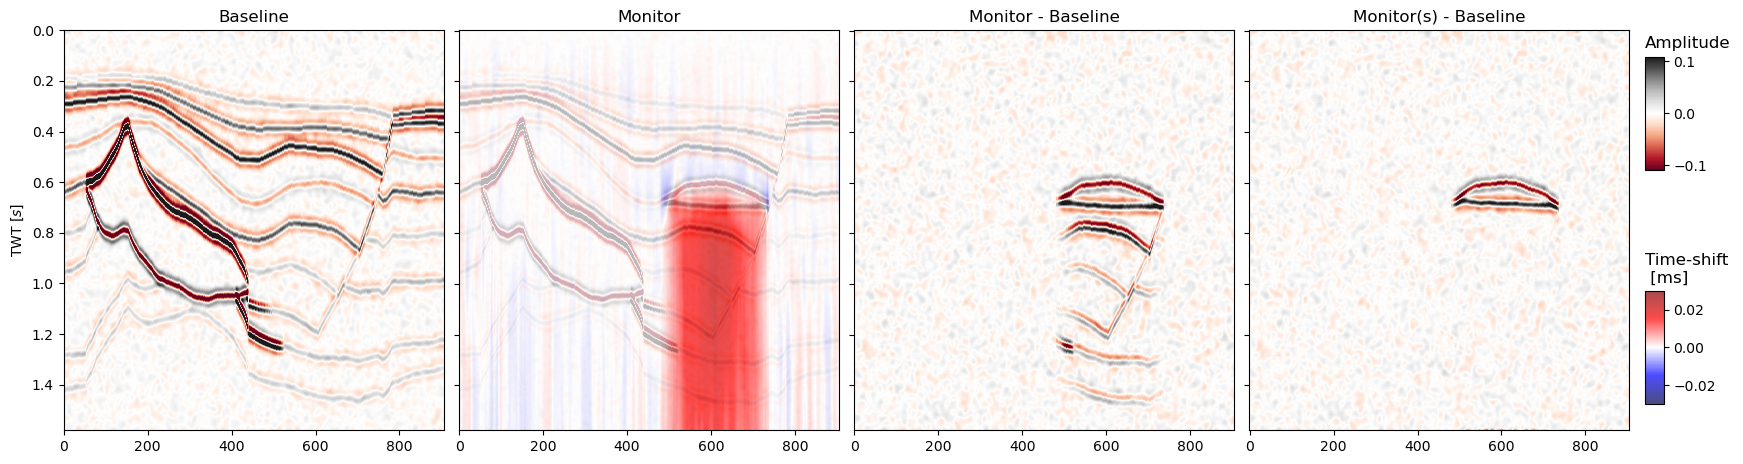

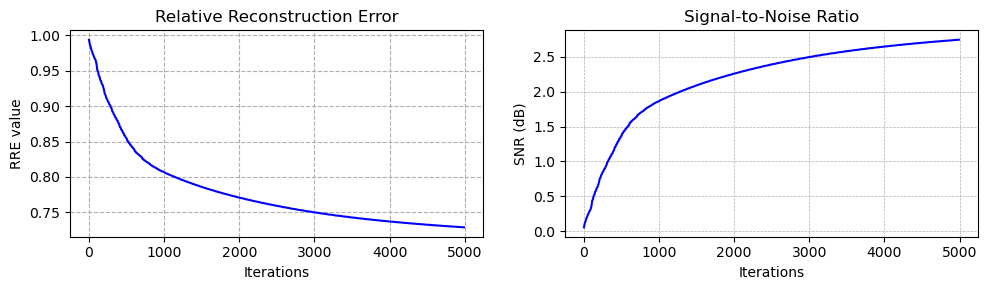

In [5]:
# Algorithm parameters
l2niter = 10    # Number of iterations for L2 proximal solver
pdniter = 10    # Number of iterations for Primal-Dual solver
outeriter = 50  # Number of outer iterations

# Set up operators
G = PoststackLinearModelling(wav/2, nt0=dims[0], spatdims=dims[1:])
Dop = Gradient(dims=dims, edge=True, dtype=dtype, kind='forward')
l1 = L21(ndim=len(dims), sigma=1.)
C = CausalIntegration(dims=dims, axis=0, sampling=dt, dtype=dtype)
D = FirstDerivative(dims=dims, axis=0, sampling=dt, dtype=dtype)

# Initialize variables
ui = np.zeros(np.prod(dims))  # Initial strain estimate
d2i = d2.copy()               # Initial shifted monitor data

# Step size parameters
L = 8.  # Approximation of np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
mu = 0.1
tau = 0.99 / (mu * L)

# Metrics storage
xhist, xsnr, xerr = [], [], []

# Run the inversion
start_time = time.perf_counter()
for i in range(outeriter):
    # Calculate data residual
    d = d1.ravel() - d2i.ravel()  
    
    # Set up the Jacobian and operator
    J = Diagonal(D*d2i, dtype=dtype)
    Op = J * C
    
    # Set up the L2 norm
    l2 = L2(Op=Op, b=d, niter=l2niter, warm=True, x0=np.zeros(np.prod(dims)))
    
    # Gradient on the previous estimate
    gu = Dop * ui
    
    # Update strain using primal-dual algorithm
    ui += PrimalDual(
        proxf=l2, 
        proxg=l1.precomposition(a=1., b=gu), 
        A=Dop, 
        tau=tau, 
        mu=mu, 
        theta=1., 
        x0=np.zeros(np.prod(dims)), 
        niter=pdniter,
        callback=lambda xx: callbackx(xx.copy(), ui.copy(), utrue.ravel(), xhist, xsnr, xerr), 
        show=False
    )
    
    # Update shifted monitor data
    d2i = apply_time_shift(t, ui, d2, C, dims)
    
    # Print progress
    if i % 10 == 0:
        print(f'iter: {i}, SNR: {xsnr[-1]:.4f}')     

total_time = time.perf_counter() - start_time
print(f'Total time: {total_time:.2f} s')

# Plot results
plot_results(ui, d1, d2, d2i, C, dims, dt, xerr, xsnr, l2niter)

## Time-strain inversion with data term

$$
     \Delta u = \argmin_{\Delta u}\Vert d_1(t) - d_2(t+ dt C  u_{i-1}) - G(u_{i-1}) -  (G + dt  J_{d_2} C) \Delta u \Vert^2  + \Vert \nabla (\Delta u + u_{i-1})\Vert_{1}
$$

iter: 0, SNR: 0.7202
iter: 10, SNR: 1.8670
Total time: 252.49 s


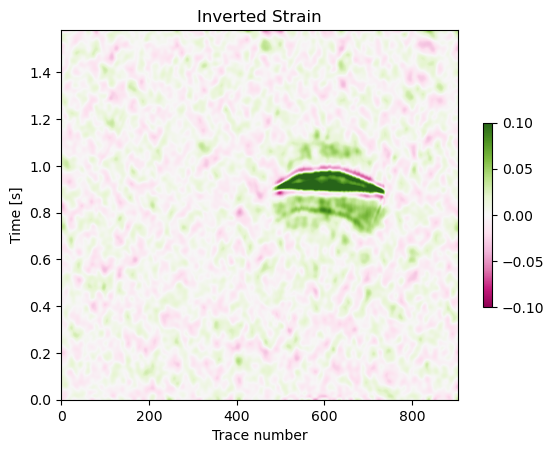

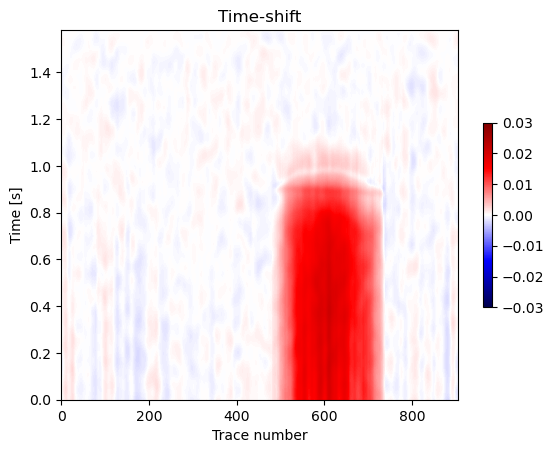

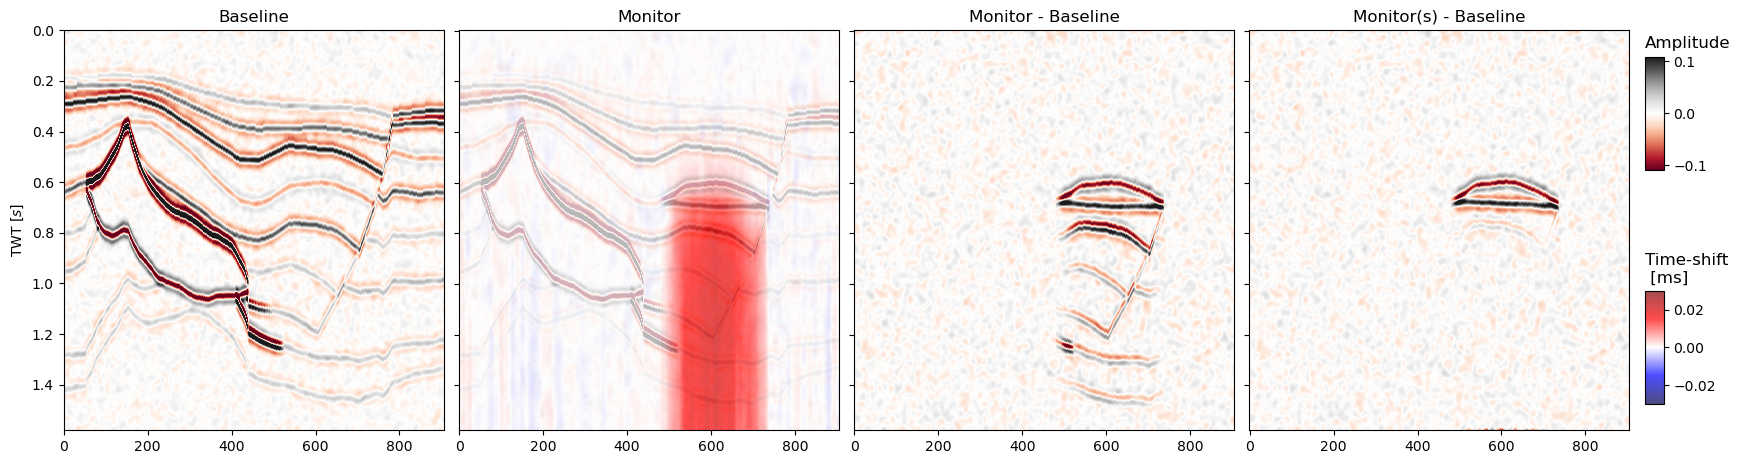

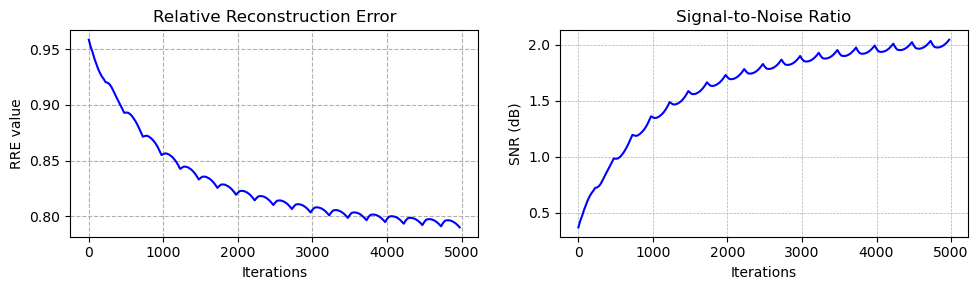

In [6]:
# Algorithm parameters
l2niter = 25    # Number of iterations for L2 proximal solver
pdniter = 10    # Number of iterations for Primal-Dual solver
outeriter = 20  # Number of outer iterations

# Set up operators
G = PoststackLinearModelling(wav/2, nt0=dims[0], spatdims=dims[1:])
Dop = Gradient(dims=dims, edge=True, dtype=dtype, kind='forward')
l1 = L21(ndim=len(dims), sigma=1.)
C = CausalIntegration(dims=dims, axis=0, sampling=dt, dtype=dtype)
D = FirstDerivative(dims=dims, axis=0, sampling=dt, dtype=dtype)

# Initialize variables
ui = np.zeros(np.prod(dims))  # Initial strain estimate
d2i = d2.copy()               # Initial shifted monitor data

# Step size parameters
L = 8.  # Approximation of np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
mu = 0.1
tau = 0.99 / (mu * L)

# Metrics storage
xhist, xsnr, xerr = [], [], []

# Run the inversion
start_time = time.perf_counter()
for i in range(outeriter):
    # Calculate data residual
    d = d1.ravel() - d2i.ravel() - (G*ui)
    
    # Set up the Jacobian and operator
    J = Diagonal(D*d2i, dtype=dtype)
    Op = G + J * C
    
    # Set up the L2 norm
    l2 = L2(Op=Op, b=d, niter=l2niter, warm=True, x0=np.zeros(np.prod(dims)))
    
    # Gradient on the previous estimate
    gu = Dop * ui
    
    # Update strain using primal-dual algorithm
    ui += PrimalDual(
        proxf=l2, 
        proxg=l1.precomposition(a=1., b=gu), 
        A=Dop, 
        tau=tau, 
        mu=mu, 
        theta=1., 
        x0=np.zeros(np.prod(dims)), 
        niter=pdniter,
        callback=lambda xx: callbackx(xx.copy(), ui.copy(), utrue.ravel(), xhist, xsnr, xerr), 
        show=False
    )
    
    # Update shifted monitor data
    d2i = apply_time_shift(t, ui, d2, C, dims)
    
    # Print progress
    if i % 10 == 0:
        print(f'iter: {i}, SNR: {xsnr[-1]:.4f}')     

total_time = time.perf_counter() - start_time
print(f'Total time: {total_time:.2f} s')

# Plot results
plot_results(ui, d1, d2, d2i, C, dims, dt, xerr, xsnr, l2niter)

In [ ]:
np.savez('../results/tv_results', strain=ui, d2s=d2i, snr=xsnr)

## Joint-inversion and segmentation

Working with alpha=10.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 5.107978315573004
||v-v_old||_2= 410.3279786749455
||m-m_old||_2= 6.4551093760946285
Iteration 1...
f= 7.104705634674306
||v-v_old||_2= 17.990525106236547
||m-m_old||_2= 2.423944586795727
Working with alpha=10.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 30.89181614584606
||v-v_old||_2= 410.3768841350434
||m-m_old||_2= 3.0974948840973253
Iteration 1...
f= 22.295160151303733
||v-v_old||_2= 21.043045353512902
||m-m_old||_2= 2.6848432372213087
Working with alpha=10.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 15.241421294688365
||v-v_old||_2= 410.35447688626596
||m-m_old||_2= 2.668554594636632
Iteration 1...
f= 16.93314368539659
||v-v_old||_2= 19.96226353924847
||m-m_old||_2= 2.6085927584111914
Working with alpha=10.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 26.683148192766634
||v-v_old||_2= 410.34496196375375
||m-m_old||_2= 2.630273905024565
Iteration 1...
f= 23.78

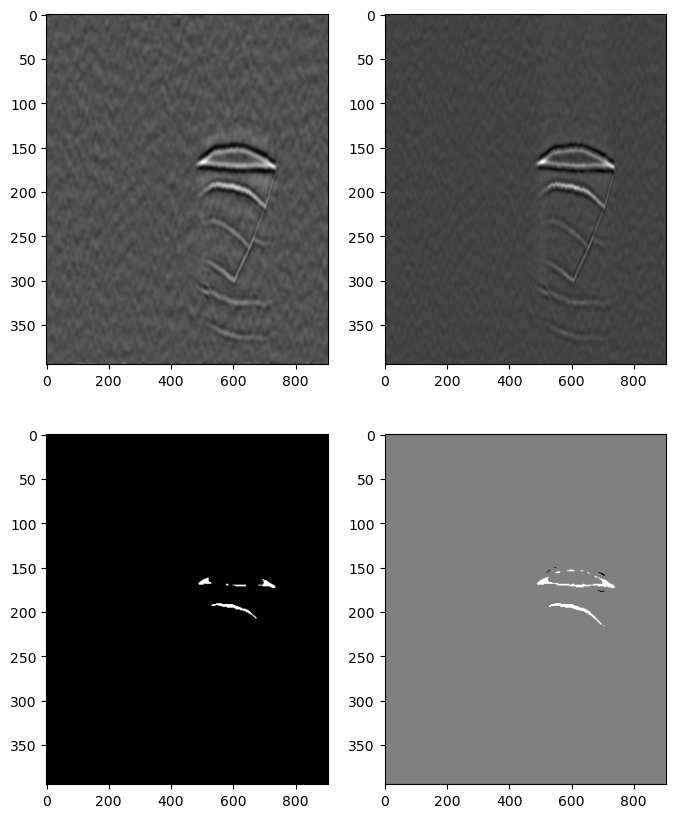

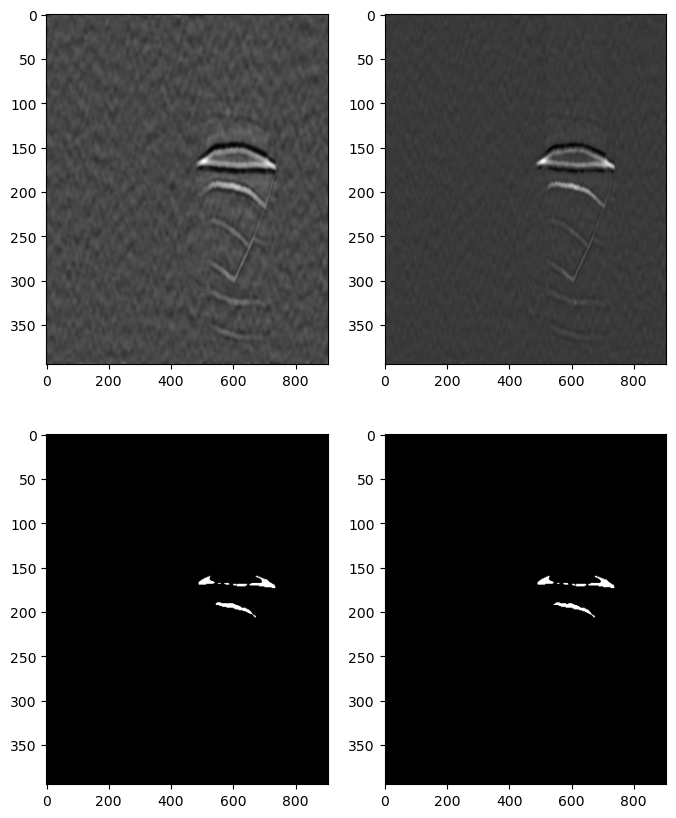

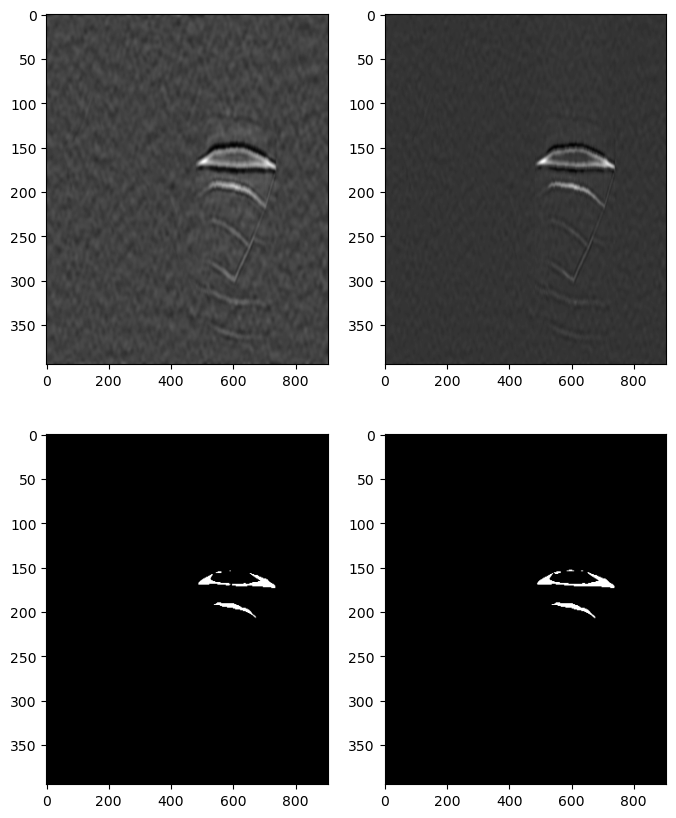

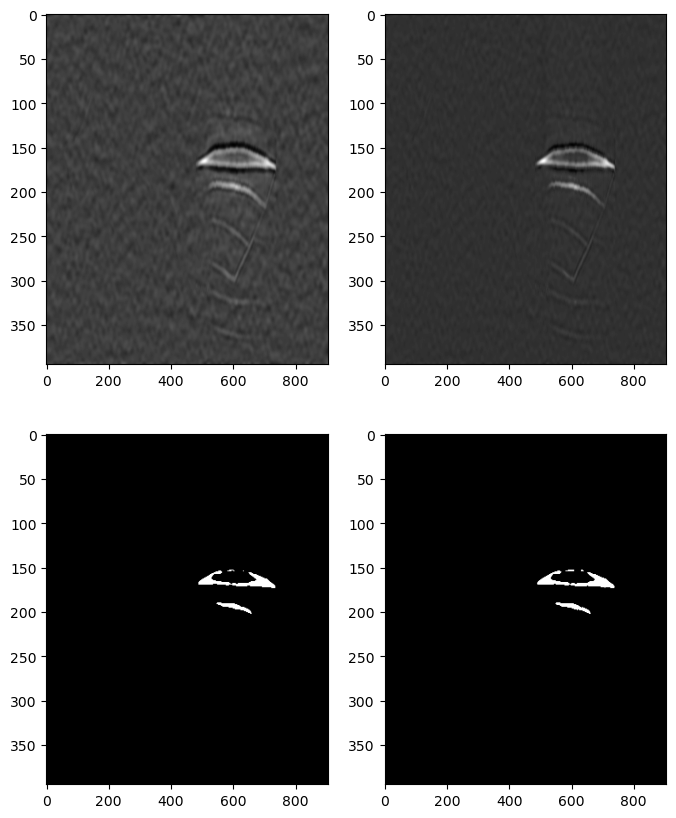

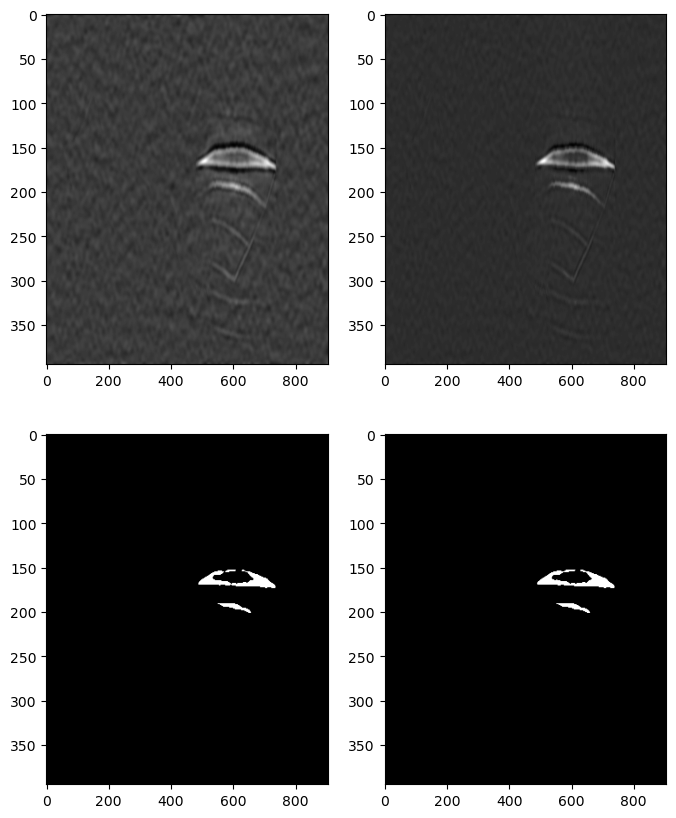

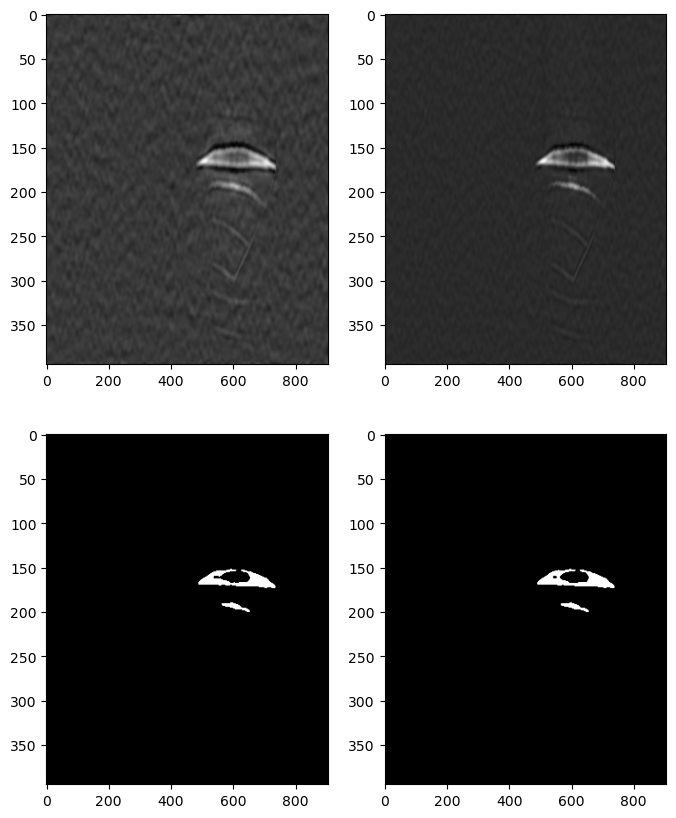

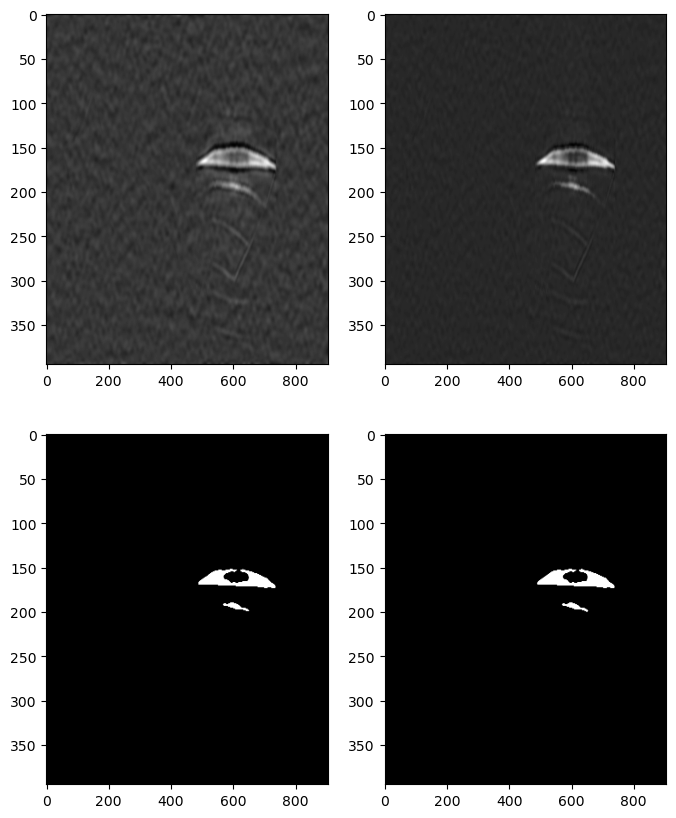

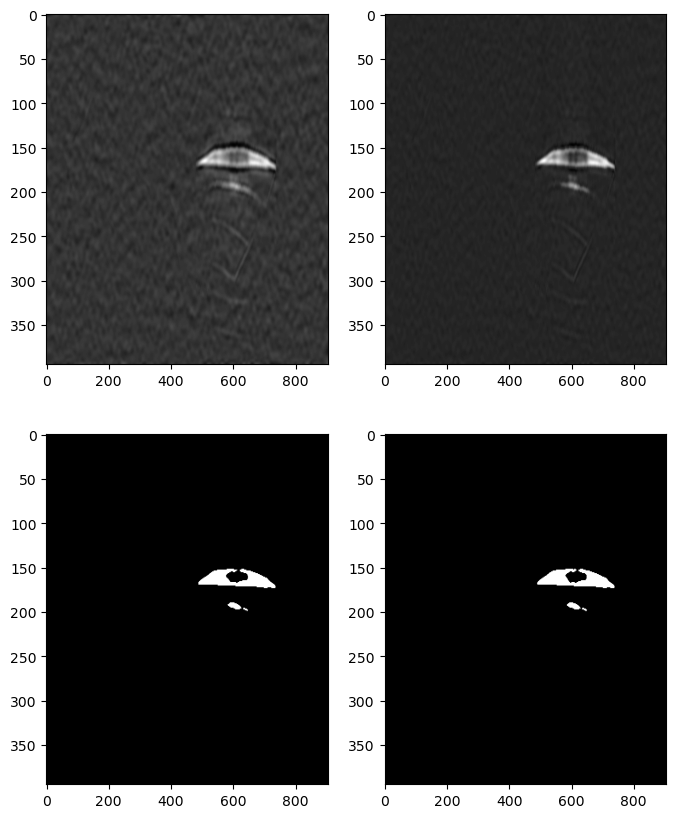

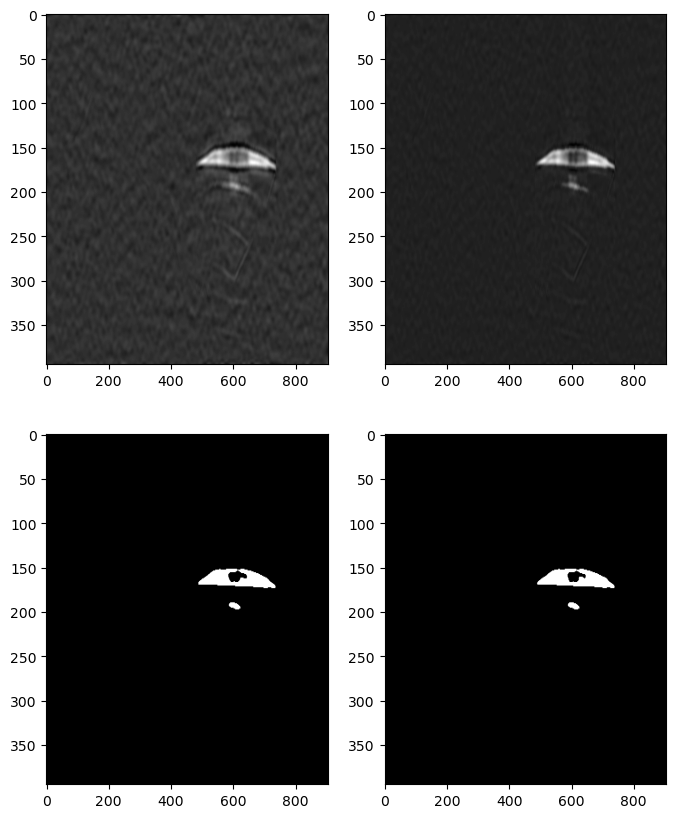

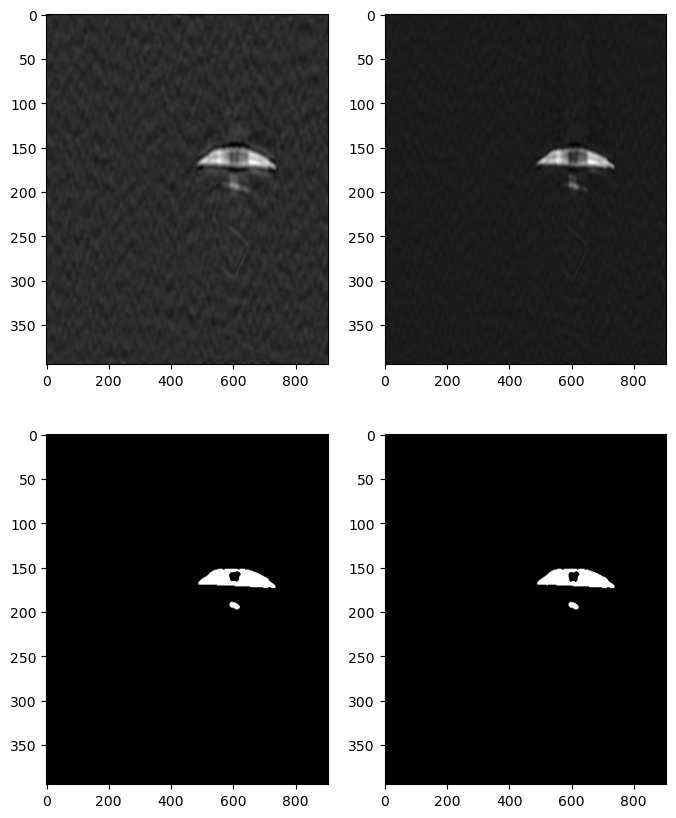

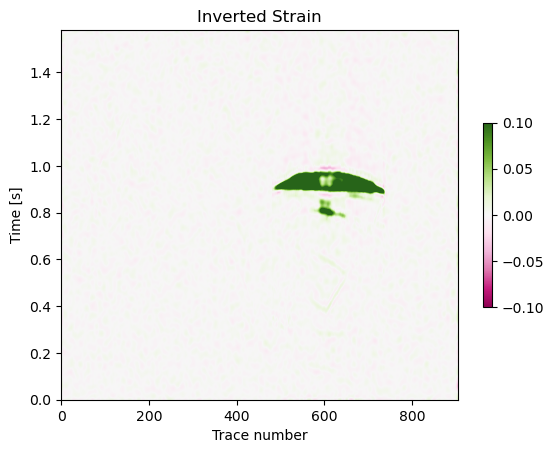

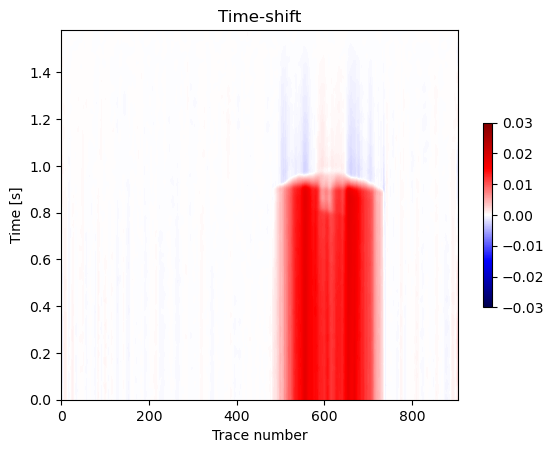

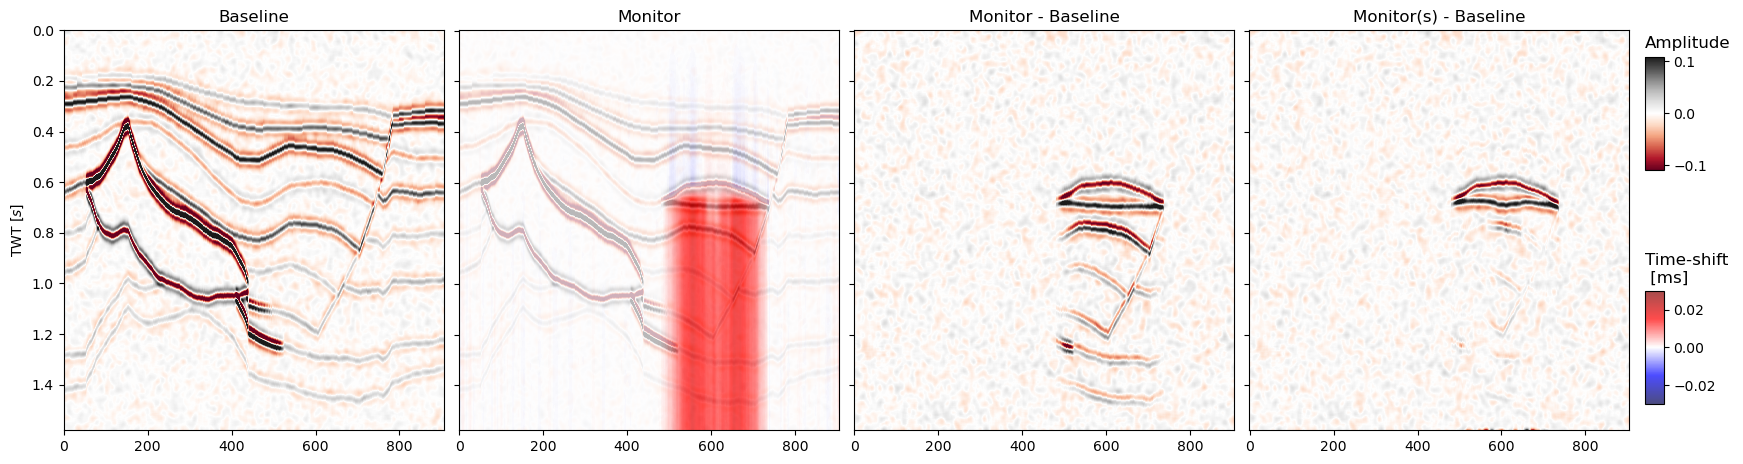

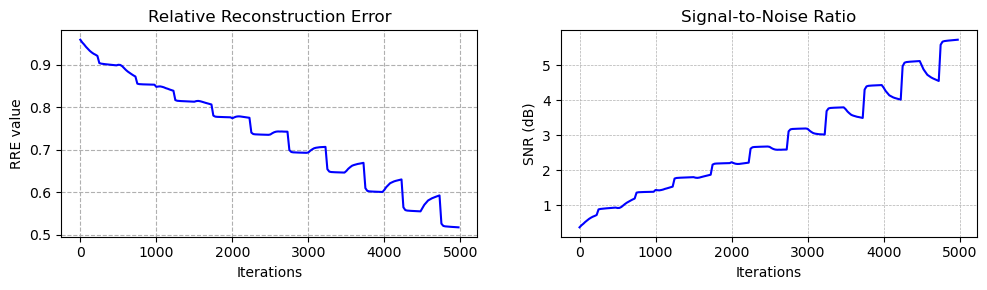

In [3]:
outeriter = 10  # Number of JIS iterations
niter = 2           # Number of inner iterations in JIS
segmentniter = 10   # Number of segmentation iterations
bisectniter = 10    # Number of bisection iterations
l2niter = 25        # Number of iterations for L2 proximal solver
pdniter = 10        # Number of iterations for Primal-Dual solver

# Set up operators
G = PoststackLinearModelling(wav/2, nt0=dims[0], spatdims=dims[1:])
Dop = Gradient(dims=dims, edge=True, dtype=dtype, kind='forward')
l1 = L21(ndim=len(dims), sigma=1.)
C = CausalIntegration(dims=dims, axis=0, sampling=dt, dtype=dtype)
D = FirstDerivative(dims=dims, axis=0, sampling=dt, dtype=dtype)


# Initialize variables
ui = np.zeros(np.prod(dims))  # Initial strain estimate
d2i = d2.copy()               # Initial shifted monitor data

# Segmentation parameters
cl = np.array([-0.15, 0, 0.15])  # Class values
alpha = 10.  # TV regularization weight for inversion
beta = 10.   # TV regularization weight for segmentation
delta = 2.   # Segmentation misfit weight

# Step size parameters
L = 8.  # Approximation of np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
mu = 0.1
tau = 0.99 / (mu * L)

# Metrics storage
xsnr, xerr = [], []

# Run the joint inversion and segmentation
start_time = time.perf_counter()
for i in range(outeriter):
    # Calculate data residual
    d = d1.ravel() - d2i.ravel() - (G*ui)
    
    # Set up the Jacobian and operator
    J = Diagonal(D*d2i, dtype='float32')
    Op = G + J * C
    
    # Run one step of joint inversion and segmentation
    ui, v, vcl, xerr_, xsnr_ = strain_jis(
        d=d, 
        Op=Op, 
        x0=np.zeros(np.prod(dims)), 
        ui=ui, 
        dims=dims, 
        cl=cl, 
        alpha=alpha, 
        beta=beta, 
        delta=delta, 
        tau=tau, 
        mu=mu,
        niter=niter, 
        l2niter=l2niter, 
        pdniter=pdniter,
        segmentniter=segmentniter, 
        bisectniter=bisectniter, 
        bregman=False,
        utrue=utrue, 
        plotflag=True, 
        show=False
    )
    
    # Update shifted monitor data
    d2i = apply_time_shift(t, ui, d2, C, dims)
    
    # Accumulate metrics
    xsnr += xsnr_
    xerr += xerr_   

total_time = time.perf_counter() - start_time
print(f'Total time (JIS): {total_time:.2f} s')

# Plot results
plt.show()  # Show any pending plots from strain_jis
plot_results(ui, d1, d2, d2i, C, dims, dt, xerr, xsnr, l2niter)

In [ ]:
np.savez('../results/purejis_results', strain=ui, d2s=d2i, snr=xsnr)

## Joint-inversion-segmentation with TV inversion as precursor

Starting TV inversion...
Total time (TV-inversion): 125.84 s
Starting joint inversion and segmentation...
Working with alpha=1.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 32.479530231023126
||v-v_old||_2= 412.2895168180428
||m-m_old||_2= 0.28760134669442994
Iteration 1...
f= 27.239000313888862
||v-v_old||_2= 35.062010359694646
||m-m_old||_2= 4.419282366985849
Working with alpha=1.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 27.087090602169734
||v-v_old||_2= 410.6313497330237
||m-m_old||_2= 2.457494613626756
Iteration 1...
f= 27.45550389254208
||v-v_old||_2= 22.998170952873746
||m-m_old||_2= 3.079299840573523
Working with alpha=1.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 31.81911508651258
||v-v_old||_2= 410.42416014214916
||m-m_old||_2= 2.3218628200717246
Iteration 1...
f= 32.765118665729105
||v-v_old||_2= 21.64075465249229
||m-m_old||_2= 3.0797379063032095
Working with alpha=1.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 35.02

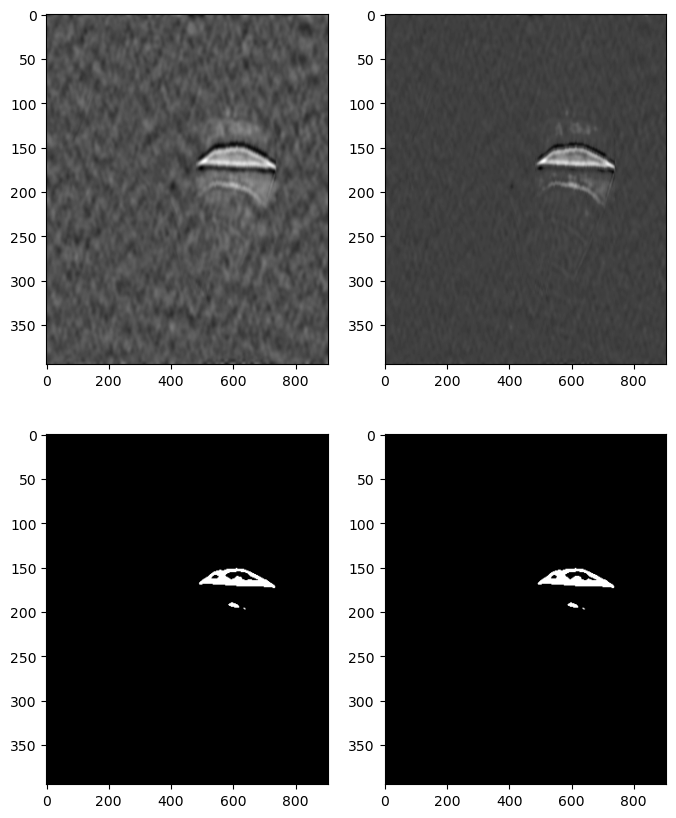

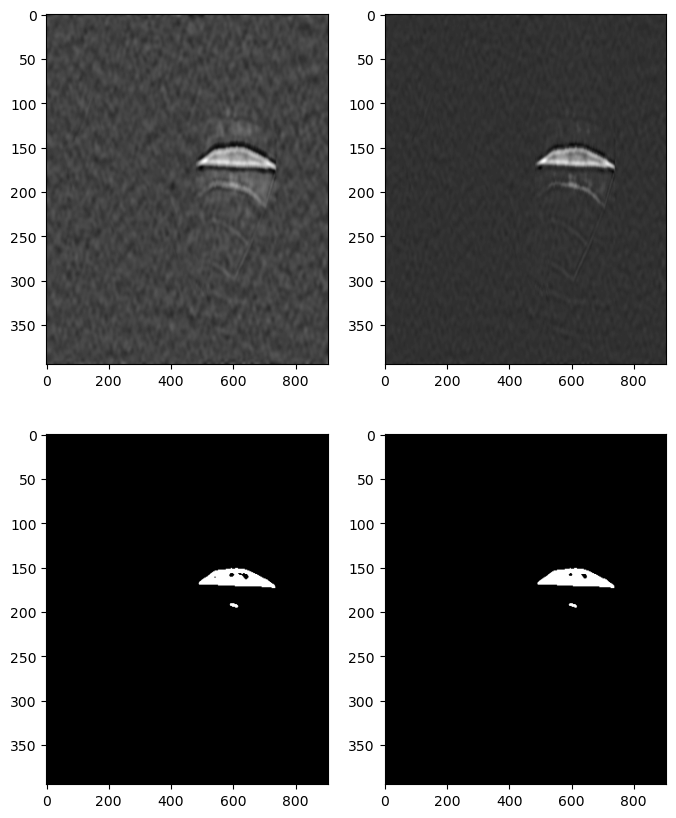

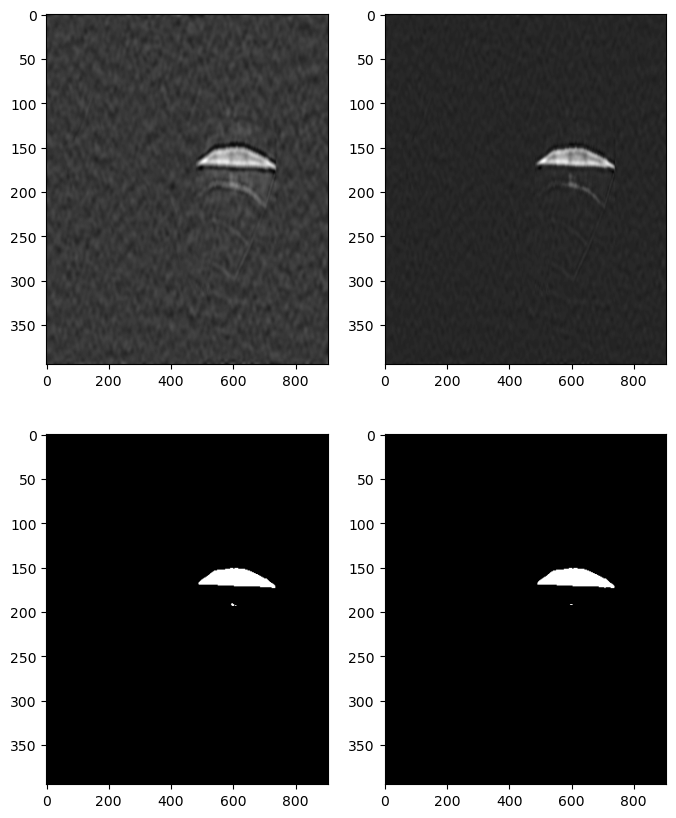

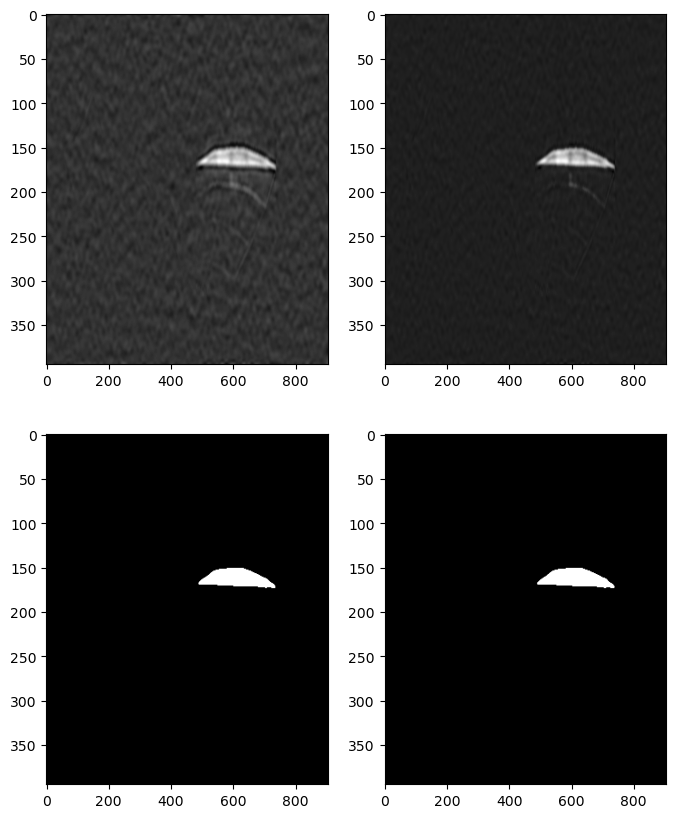

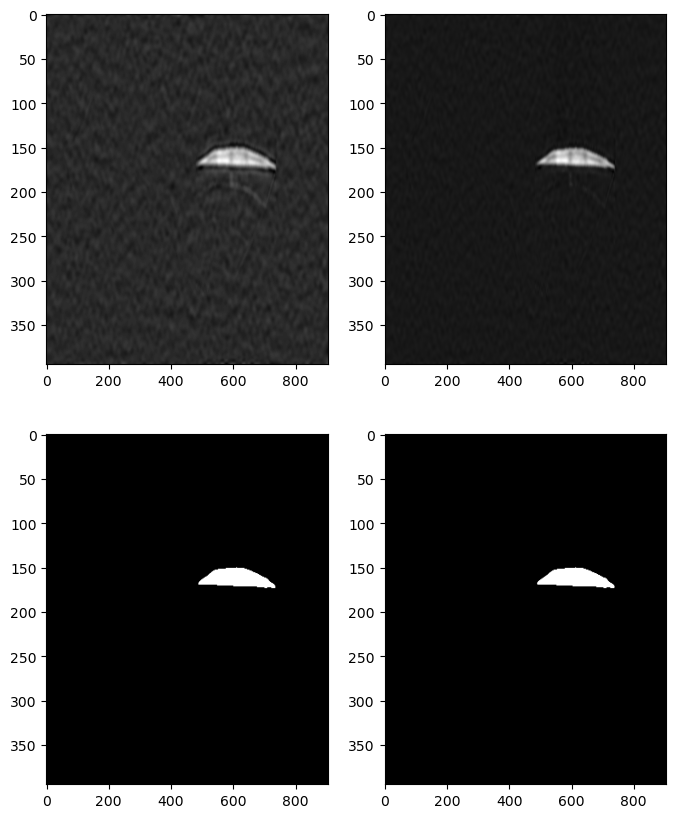

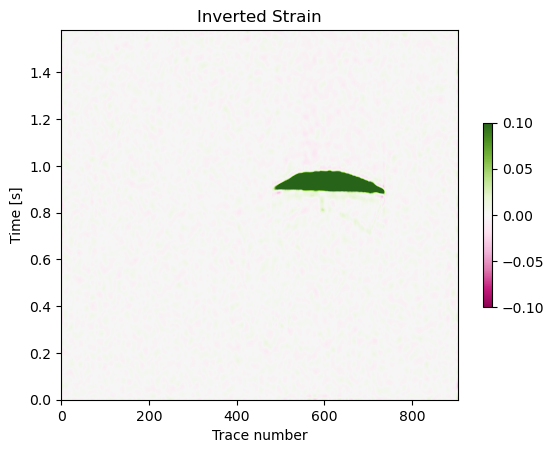

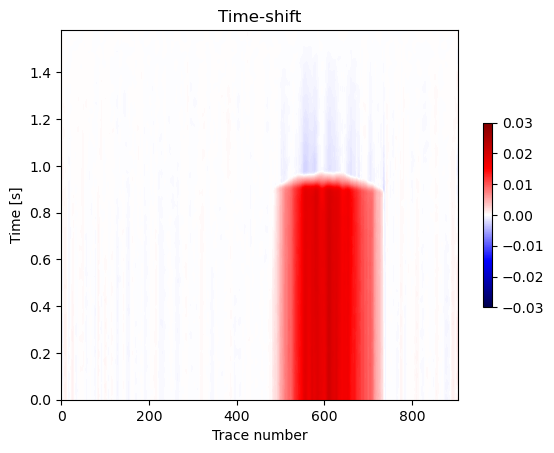

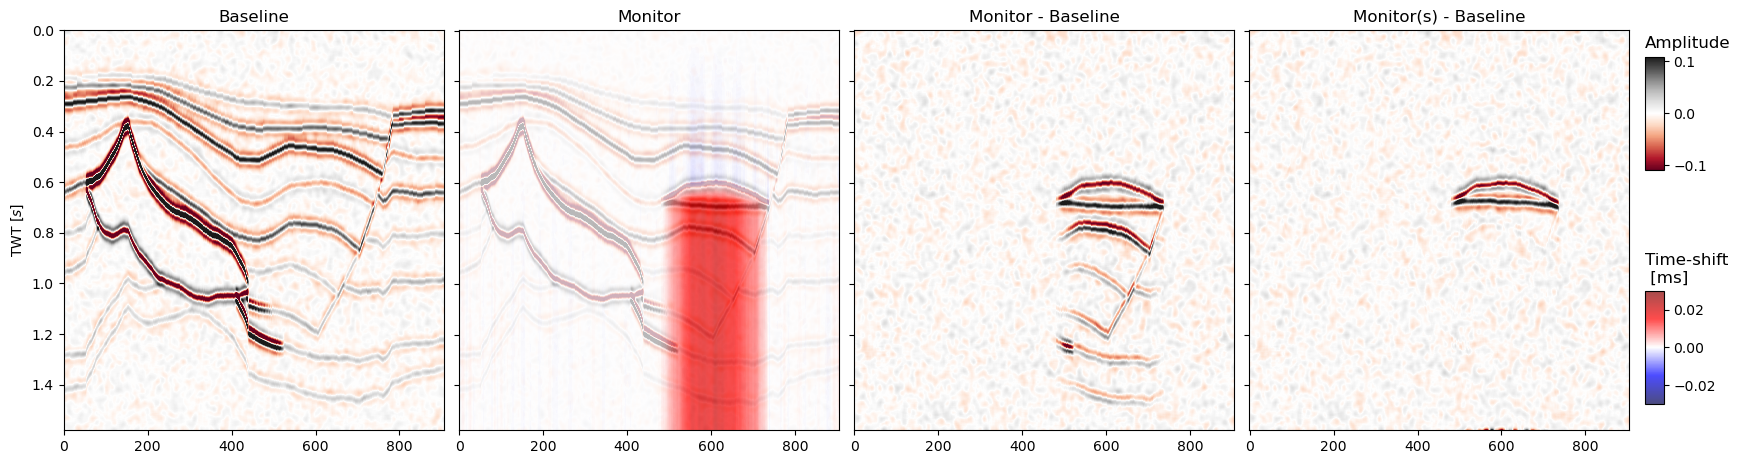

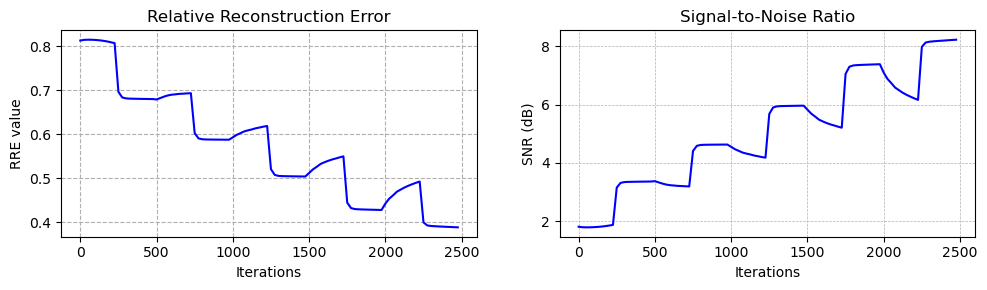

In [3]:
outeriter_tv = 10  # Number of TV inversion iterations
l2niter = 25       # Number of L2 iterations
pdniter = 10       # Number of Primal-Dual iterations

# Set up operators
G = PoststackLinearModelling(wav/2, nt0=dims[0], spatdims=dims[1:])
Dop = Gradient(dims=dims, edge=True, dtype=dtype, kind='forward')
l1 = L21(ndim=len(dims), sigma=1.)
C = CausalIntegration(dims=dims, axis=0, sampling=dt, dtype=dtype)
D = FirstDerivative(dims=dims, axis=0, sampling=dt, dtype=dtype)

# Initialize variables
ui = np.zeros(np.prod(dims))  # Initial strain estimate
d2i = d2.copy()               # Initial shifted monitor data

# Step size parameters
L = 8.  # Approximation of np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
mu = 0.1
tau = 0.99 / (mu * L)

# Metrics storage
xhist, xsnr, xerr = [], [], []

# Run TV inversion
print("Starting TV inversion...")
start_time = time.perf_counter()

for i in range(outeriter_tv):
    # Calculate data residual
    d = d1.ravel() - d2i.ravel() - (G*ui)
    
    # Set up the Jacobian and operator
    J = Diagonal(D*d2i, dtype=dtype)
    Op = G + J * C
    
    # Set up the L2 norm
    l2 = L2(Op=Op, b=d, niter=l2niter, warm=True, x0=np.zeros(np.prod(dims)))
    
    # Gradient on the previous estimate
    gu = Dop * ui
    
    # Update strain using primal-dual algorithm
    ui += PrimalDual(
        proxf=l2, 
        proxg=l1.precomposition(a=1., b=gu), 
        A=Dop, 
        tau=tau, 
        mu=mu, 
        theta=1., 
        x0=np.zeros(np.prod(dims)), 
        niter=pdniter,
        callback=lambda xx: callbackx(xx.copy(), ui.copy(), utrue.ravel(), xhist, xsnr, xerr), 
        show=False
    )
    
    # Update shifted monitor data
    d2i = apply_time_shift(t, ui, d2, C, dims)

tv_time = time.perf_counter() - start_time
print(f'Total time (TV-inversion): {tv_time:.2f} s')

# Second part: Joint inversion and segmentation
outeriter_jis = 5   # Number of JIS iterations
niter = 2           # Number of inner iterations in JIS
segmentniter = 10   # Number of segmentation iterations
bisectniter = 10    # Number of bisection iterations

# Segmentation parameters
cl = np.array([-0.15, 0, 0.15])  # Class values
alpha = 1.   # TV regularization weight for inversion
beta = 10.   # TV regularization weight for segmentation
delta = 2.   # Segmentation misfit weight

# Prepare for JIS
jis_xsnr = []
jis_xerr = []

# Run joint inversion and segmentation
print("Starting joint inversion and segmentation...")
start_time = time.perf_counter()

for i in range(outeriter_jis):
    # Calculate data residual
    d = d1.ravel() - d2i.ravel() - (G*ui)
    
    # Set up the Jacobian and operator
    J = Diagonal(D*d2i, dtype='float32')
    Op = G + J * C
    
    # Run one step of joint inversion and segmentation
    ui, v, vcl, xerr_, xsnr_ = strain_jis(
        d=d, 
        Op=Op, 
        x0=np.zeros(np.prod(dims)), 
        ui=ui, 
        dims=dims, 
        cl=cl, 
        alpha=alpha, 
        beta=beta, 
        delta=delta, 
        tau=tau, 
        mu=mu,
        niter=niter, 
        l2niter=l2niter, 
        pdniter=pdniter,
        segmentniter=segmentniter, 
        bisectniter=bisectniter, 
        bregman=False,
        utrue=utrue, 
        plotflag=True, 
        show=False
    )
    
    # Update shifted monitor data
    d2i = apply_time_shift(t, ui, d2, C, dims)
    
    # Accumulate metrics
    jis_xsnr += xsnr_
    jis_xerr += xerr_

jis_time = time.perf_counter() - start_time
print(f'Total time (JIS): {jis_time:.2f} s')
print(f'Total time (Hybrid): {tv_time + jis_time:.2f} s')

# Plot results
plt.show()  # Show any pending plots from strain_jis
plot_results(ui, d1, d2, d2i, C, dims, dt, jis_xerr, jis_xsnr, l2niter)

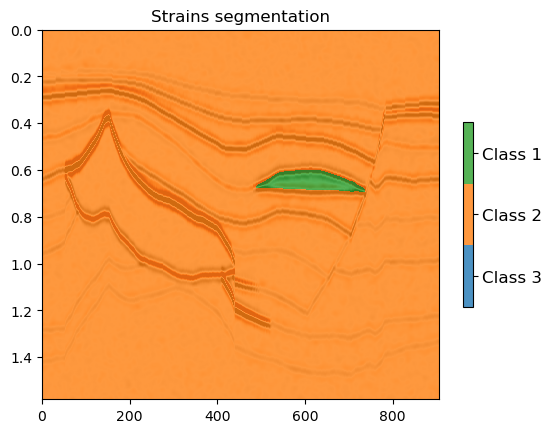

In [4]:
class_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
cmap = ListedColormap(class_colors)
bounds = [-1.5, -0.5, 0.5, 1.5]  # Boundaries for classes (-1, 0, 1)
norm = BoundaryNorm(bounds, len(class_colors))
# plt.figure(figsize=(8, 8))
plt.imshow(d2, cmap='RdGy',vmin=-0.1, vmax=0.1, extent=(0, dims[1], dims[0]*dt, 0))
im = plt.imshow(vcl.reshape(dims)-1, cmap=cmap, norm=norm, extent=(0, dims[1], dims[0]*dt, 0), alpha=0.8)
cbar = plt.colorbar(im, boundaries=bounds, ticks=[-1, 0, 1], shrink=0.5)
cbar.ax.set_yticklabels(['Class 3', 'Class 2', 'Class 1'], fontsize=12)
plt.title('Strains segmentation')
plt.axis('tight')
plt.show()

In [6]:
np.savez('../results/jis_results', strain=ui, d2s=d2i, vcl=vcl.reshape(dims))